In [0]:
import torchvision
import torch
from torch import nn, optim
import numpy as np
from torchtools.vq import VectorQuantize
from torchtools.optim import RAdam
import matplotlib.pyplot as plt

In [0]:
dataset = torchvision.datasets.MNIST('mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

dataset_val = torchvision.datasets.MNIST('mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()       
        self.classifier = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
        
        self.apply(weights_init)
                
    def forward(self, x):
        x = self.classifier(x)
        return x

mlp = MLP()
mlp.cuda()

In [0]:
epochs = 10
optimizer = optim.Adam(mlp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
regular_losses, regular_train_losses = [], []
regular_accuracies, regular_train_accuracies = [], []
for e in range(1, epochs+1):
    test_loss = 0
    test_acc = 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        pred = mlp.forward(images.view(-1, 784))        
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        test_loss += loss.item()
        acc = (pred.argmax(dim=-1) == labels).float().mean()
        test_acc += acc.item()
    
    regular_train_losses.append(test_loss/len(loader))
    regular_train_accuracies.append(test_acc/len(loader))
    
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            pred = mlp.forward(images.view(-1, 784))        
            loss = criterion(pred, labels) 
            
            val_loss += loss.item()
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            val_acc += acc.item()
    
    regular_losses.append(val_loss/len(loader_val))
    regular_accuracies.append(val_acc/len(loader_val))
    print(f"EPOCH {e} - loss {val_loss/len(loader_val)} - acc {val_acc/len(loader_val)}")

AssertionError: Torch not compiled with CUDA enabled

In [0]:
epochs = 10
optimizer = RAdam(mlp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
regular_losses_r, regular_train_losses_r = [], []
regular_accuracies_r, regular_train_accuracies_r = [], []
for e in range(1, epochs+1):
    test_loss = 0
    test_acc = 0
    for images, labels in loader:
        # images, labels = images.cuda(), labels.cuda()
        pred = mlp.forward(images.view(-1, 784))        
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        test_loss += loss.item()
        acc = (pred.argmax(dim=-1) == labels).float().mean()
        test_acc += acc.item()
    
    regular_train_losses_r.append(test_loss/len(loader))
    regular_train_accuracies_r.append(test_acc/len(loader))
    
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            pred = mlp.forward(images.view(-1, 784))        
            loss = criterion(pred, labels) 
            
            val_loss += loss.item()
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            val_acc += acc.item()
    
    regular_losses_r.append(val_loss/len(loader_val))
    regular_accuracies_r.append(val_acc/len(loader_val))
    print(f"EPOCH {e} - loss {val_loss/len(loader_val)} - acc {val_acc/len(loader_val)}")

In [0]:
class vqMLP(nn.Module):
    def __init__(self):
        super(vqMLP, self).__init__()
        
        self.embedding_size = 1
        
        self.l1 = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU()
        )
        
        self.vq1 = VectorQuantize(self.embedding_size, 512, ema_loss=True)
        
        self.l2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.vq2 = VectorQuantize(self.embedding_size, 256)
        
        self.l3 = nn.Linear(256, 10)
        
        self.apply(weights_init)
        
    def forward(self, x):
        x = self.l1(x).view(-1, 512 // self.embedding_size, self.embedding_size)
        x, (_, commit_loss1), _ = self.vq1(x)
        x = x.view(-1, 512)
        
        x = self.l2(x).view(-1, 256 // self.embedding_size, self.embedding_size)
        x, (_, commit_loss2), _ = self.vq2(x)
        x = x.view(-1, 256)
        
        x = self.l3(x)
        return x, (commit_loss1 + commit_loss2)

vqmlp = vqMLP()
vqmlp.cuda()

vqMLP(
  (l1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (vq1): VectorQuantize(
    (codebook): Embedding(512, 1)
  )
  (l2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (vq2): VectorQuantize(
    (codebook): Embedding(256, 1)
  )
  (l3): Linear(in_features=256, out_features=10, bias=True)
)

In [0]:
epochs = 10
optimizer = optim.Adam(vqmlp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
vq_losses, vq_train_losses = [], []
vq_accuracies, vq_train_accuracies = [], []
for e in range(1, epochs+1):
    vqmlp.train()
    test_loss = 0
    test_acc = 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        pred, commit_loss = vqmlp.forward(images.view(-1, 784))        
        loss = criterion(pred, labels) + commit_loss * 0.25
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        test_loss += (loss.item() - commit_loss.item() * 0.25) # remove the commit loss
        acc = (pred.argmax(dim=-1) == labels).float().mean()
        test_acc += acc.item()
    
    vq_train_losses.append(test_loss/len(loader))
    vq_train_accuracies.append(test_acc/len(loader))
    
    vqmlp.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            pred, commit_loss = vqmlp.forward(images.view(-1, 784)) 
            # for comparison purposes, let's keep the commit loss out of the equation
            loss = criterion(pred, labels) # + commit_loss * 0.25 
            
            val_loss += loss.item()
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            val_acc += acc.item()
            
    vq_losses.append(val_loss/len(loader_val))
    vq_accuracies.append(val_acc/len(loader_val))
    print(f"EPOCH {e} - loss {val_loss/len(loader_val)} - acc {val_acc/len(loader_val)}")

EPOCH 1 - loss 0.43257518918514254 - acc 0.9503
EPOCH 2 - loss 0.14212108124494552 - acc 0.9707
EPOCH 3 - loss 0.1026342918753624 - acc 0.9748
EPOCH 4 - loss 0.08371566772460938 - acc 0.977
EPOCH 5 - loss 0.07975721381902695 - acc 0.9778
EPOCH 6 - loss 0.07575446336269379 - acc 0.9786
EPOCH 7 - loss 0.08226723456978798 - acc 0.9781
EPOCH 8 - loss 0.08029426817893982 - acc 0.9775
EPOCH 9 - loss 0.07288837142586709 - acc 0.9794
EPOCH 10 - loss 0.0702545889377594 - acc 0.9811


In [0]:
epochs = 10
optimizer = optim.Adam(vqmlp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
vq_losses_r, vq_train_losses_r = [], []
vq_accuracies_r, vq_train_accuracies_r = [], []
for e in range(1, epochs+1):
    vqmlp.train()
    test_loss = 0
    test_acc = 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        pred, commit_loss = vqmlp.forward(images.view(-1, 784))        
        loss = criterion(pred, labels) + commit_loss * 0.25
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        test_loss += (loss.item() - commit_loss.item() * 0.25) # remove the commit loss
        acc = (pred.argmax(dim=-1) == labels).float().mean()
        test_acc += acc.item()
    
    vq_train_losses_r.append(test_loss/len(loader))
    vq_train_accuracies_r.append(test_acc/len(loader))
    
    vqmlp.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            pred, commit_loss = vqmlp.forward(images.view(-1, 784)) 
            # for comparison purposes, let's keep the commit loss out of the equation
            loss = criterion(pred, labels) # + commit_loss * 0.25 
            
            val_loss += loss.item()
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            val_acc += acc.item()
            
    vq_losses_r.append(val_loss/len(loader_val))
    vq_accuracies_r.append(val_acc/len(loader_val))
    print(f"EPOCH {e} - loss {val_loss/len(loader_val)} - acc {val_acc/len(loader_val)}")

In [0]:
# Let's compare the number of parameters:

mlp_param_count = sum([p.numel() for p in mlp.parameters()])
vqmlp_param_count = sum([p.numel() for p in vqmlp.parameters()])

print("MLP", mlp_param_count)
print("vqMLP", vqmlp_param_count)
print(f"vqMLP has {vqmlp_param_count-mlp_param_count} parameters more.")

MLP 535818
vqMLP 536586
vqMLP has 768 parameters more.


[0.23132744488716125, 0.20359286821484565, 0.2183299045562744, 0.20119987473487855, 0.22391787838935853, 0.22000187500715257, 0.3061968939602375, 0.202169755589962, 0.28151103110313414, 0.2539476370453835]


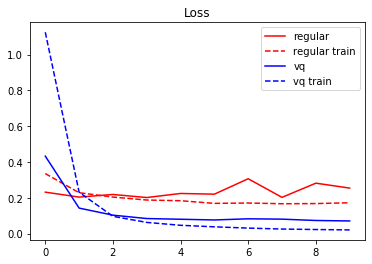

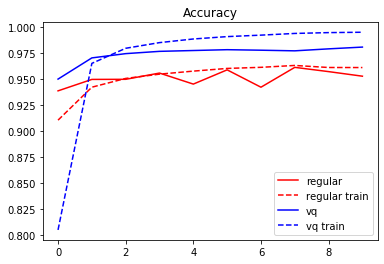

In [0]:
print(regular_losses)

plt.plot(regular_losses, marker='', color='red', label="regular")
plt.plot(regular_train_losses, marker='', color='red', label="regular train", linestyle='--')
plt.plot(vq_losses, marker='', color='blue', label="vq")
plt.plot(vq_train_losses, marker='', color='blue', label="vq train", linestyle='--')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(regular_accuracies, marker='', color='red', label="regular")
plt.plot(regular_train_accuracies, marker='', color='red', label="regular train", linestyle='--')
plt.plot(vq_accuracies, marker='', color='blue', label="vq")
plt.plot(vq_train_accuracies, marker='', color='blue', label="vq train", linestyle='--')
plt.legend()
plt.title('Accuracy')
plt.show()